In [1]:
!pip install catboost
# !pip install probatus
# !pip install numba==0.56.0
!pip install BorutaShap
!pip install scikit-learn==1.1.3
!pip install mlflow
!pip install imbalanced-learn
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 32.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 6.1 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=97b6d490a9487581c35b32ea63ff574a1dc388f1628d74466eec5417c937070b
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a09c1868a59d0b05013484e07af97a9d7b3dbd5bd39a
Successfully built databricks-cli


In [60]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier, Pool, cv, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, BaseCrossValidator
import optuna


import os
import json
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

import shap
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [61]:
data_fac = pd.read_parquet('/kaggle/input/dataset-hack-nizhniy-novgorod/factor_analysis.parquet')
data_fac

,report_date,feature_name,not_null_percent,mode_frequency,ind_gini,cor_group
0,2021-02-01,col1271,0.000000,NaN,0.132,8.0
1,2021-02-01,col2271,0.083333,0.222222,0.006,1.0
2,2021-02-01,col245,0.000000,NaN,0.022,12.0
3,2021-02-01,col2548,0.027778,0.333333,0.172,1.0
4,2021-02-01,col336,0.000000,NaN,0.144,1.0
...,...,...,...,...,...,...
66570,2022-11-01,col1707,0.000000,NaN,0.800,54.0
66571,2022-12-01,col1698,0.000000,NaN,0.308,70.0
66572,2022-12-01,col1806,0.000000,NaN,0.444,72.0
66573,2023-01-01,col1708,0.000000,NaN,0.800,54.0


### Применяем факторный анализ

In [92]:
features = data_fac[
    (data_fac['ind_gini']>0.001)
    & (data_fac['not_null_percent'] > 0.05)
    & (data_fac['mode_frequency'] < 0.8)
#     & (~data_fac['report_date'].isin(list(data_fac['report_date'].sort_values(ascending=True).unique())[-3:]))
]['feature_name'].unique()

len(features)

879

In [347]:
cols = ['target', 'report_date', 'client_id','col520', 'col552', 'col543', 'col527', 'col607', 'col600', 'col599',
    'col560', 'col548', 'col551', 'col535', 'col540', 'col464', 'col152', 
    'col228', 'col559', 'col460', 'col472', 'col568', 'col468']

df = pd.read_parquet(
    '/kaggle/input/dataset-hack-nizhniy-novgorod/data_v1/data_v1',
    columns = cols + list(features)
)
df['report_date'] = pd.to_datetime(df['report_date'])

df_buf = df[['target', 'report_date', 'client_id']]

# df = df[df.columns[~df.columns.isin(list(df.select_dtypes('object').columns)+['col1454'])]]
# df = df[df.columns[df.columns.isin(list(df.select_dtypes('object').columns)+['target', 'report_date', 'client_id'])]]
# df = df[df.columns[~df.columns.isin(['col1454'])]]

try:
    df = df.drop(columns = ['col1454'])
except:
    pass

display(df.head())
display(df.shape)

,target,report_date,client_id,col520,col552,col543,col527,col607,col600,col599,...,col2391,col2089,col2041,col1456,col414,col1949,col1994,col2148,col1855,col1944
0,0,2021-02-01,68,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2021-02-01,375,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2021-02-01,406,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,0,2021-02-01,434,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0
4,0,2021-02-01,497,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(14456, 902)

In [348]:
df[df['client_id']==1898]['target']

10      0
5506    0
6177    1
7125    1
8125    1
Name: target, dtype: int64

In [349]:
df[df['report_date']=='2022-11-01']['target'].value_counts()

target
0    926
1     21
Name: count, dtype: int64

In [350]:
df_test = df[df['report_date'].isin(list(df['report_date'].sort_values(ascending=True).unique())[-3:])]
# df_train = df[~df['report_date'].isin(list(df['report_date'].sort_values(ascending=True).unique())[-3:])]

df_train = df[df['report_date'].isin(list(df['report_date'].sort_values(ascending=True).unique())[-6:-3])]

print('Train')
display(df_train['report_date'].unique())
print('Test')
display(df_test['report_date'].unique())

Train


[2022-09-01, 2022-10-01, 2022-11-01]
Categories (25, datetime64[ns]): [2021-02-01, 2021-03-01, 2021-04-01, 2021-05-01, ..., 2022-11-01, 2022-12-01, 2023-01-01, 2023-02-01]

Test


[2022-12-01, 2023-01-01, 2023-02-01]
Categories (25, datetime64[ns]): [2021-02-01, 2021-03-01, 2021-04-01, 2021-05-01, ..., 2022-11-01, 2022-12-01, 2023-01-01, 2023-02-01]

In [351]:
# client_id = df_train[
#     (df_train['client_id'].isin(df_test['client_id']))
#     & (df_train['target']==1)
# ]['client_id']


# df_test[df_test['client_id'].isin(client_id)]

In [352]:
# data_unique = df_train['report_date'].unique()
# past_date = df_train[(df_train['report_date'].isin(data_unique[:1]))]

# display(df_train['report_date'].value_counts())

In [353]:
display(df_train['target'].value_counts())

target
0    2650
1      63
Name: count, dtype: int64

In [354]:
# zeros = df_train.loc[df_train['target']==0].sample(frac=0.1, random_state = 12345)
# df_train = df_train.loc[df_train['target']!=0]
# df_train = pd.concat([df_train, zeros])

# display(df_train.shape)
# display(df_train['target'].value_counts())

In [355]:
df_train[df_train.select_dtypes('object').columns] = df_train[df_train.select_dtypes('object').columns].astype(str)
df_test[df_test.select_dtypes('object').columns] = df_test[df_test.select_dtypes('object').columns].astype(str)

### Заполнем пропуски 

In [356]:
digit_col = df_train.columns[
    ~(df_train.columns.isin(df_train.select_dtypes('object').columns)) & 
     ~(df_train.columns.isin(df_train.select_dtypes('category').columns)) ]

In [357]:
cat_columns = df_train.select_dtypes('object').columns

In [358]:
# df_train[df_train.select_dtypes('object').columns] = df_train[df_train.select_dtypes('object').columns].fillna('пропуск')
# df_train[digit_col] = df_train[digit_col].fillna(0)

In [359]:

df_train

,target,report_date,client_id,col520,col552,col543,col527,col607,col600,col599,...,col2391,col2089,col2041,col1456,col414,col1949,col1994,col2148,col1855,col1944
8474,0,2022-09-01,7,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,15.24,35.56,8280003.76,1.0,NaN,1.0,8.0,1.4,0.0,1.0
8475,0,2022-09-01,28,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8476,0,2022-09-01,52,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8477,0,2022-09-01,89,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8478,0,2022-09-01,110,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11182,0,2022-11-01,8261,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11183,0,2022-11-01,7532,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
11184,0,2022-11-01,4898,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11185,0,2022-11-01,6315,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,miss_value,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [331]:
# from imblearn.under_sampling import EditedNearestNeighbours
# from imblearn.under_sampling import InstanceHardnessThreshold
# from sklearn.preprocessing import OrdinalEncoder


# cat_features = list(df_train.drop(columns =del_col).select_dtypes('object').columns)
# enc = OrdinalEncoder()
# df_train[cat_features] = enc.fit_transform(df_train[cat_features])

# del_col = ['target', 'report_date', 'client_id']

# iht = InstanceHardnessThreshold(cv = 7, random_state=123456, sampling_strategy = 'majority')
# # iht = EditedNearestNeighbours(n_neighbors = 200)
# X_res, y_res = iht.fit_resample(df_train.drop(columns = del_col), df_train['target'])
# display(y_res.value_counts())
# display(X_res[cat_columns])
# X_res[cat_columns] = enc.inverse_transform(X_res[cat_columns])

# display(X_res[cat_columns])
# display()

target
0    1607
1      63
Name: count, dtype: int64

In [326]:
# # df_train_v2 = 
# # df_train = df_train.sort_values(by = )
# df_train_group = df_train[df_train['target']==1].sort_values(by = ['client_id', 'report_date']).groupby('client_id').first().reset_index()#.apply(lambda x: x.isna().sum())
# df_train_group['sum_na'] = df_train_group.isna().sum(axis=1)

# col_count = len(df_train.columns)

# df_train_group = df_train_group[['target', 'sum_na']].sort_values(by = ['sum_na'])
# df_train_group['procent'] = df_train_group['sum_na'] / col_count * 100

# df_train_group['procent'].hist(bins=10)

In [327]:
# df_train.info(show_counts = True, verbose = True)

### Тестируем CatBoostClassifier

In [363]:
%%time
model = CatBoostClassifier(
    verbose = 100,
    learning_rate=0.01,
    eval_metric='AUC',
    depth = 10,
    l2_leaf_reg = 1,
#     iterations = 700,
    random_seed = 12345
) #iterations=100,

del_col = ['target', 'report_date', 'client_id']


pool_train = Pool(
#     df_train[list(good_features)+list(df_train.select_dtypes('object').columns)],#.drop(columns = del_col),
    df_train.drop(columns = del_col),

    label =  df_train['target'],
    cat_features = list(df_train.drop(columns =del_col).select_dtypes('object').columns)
   
)


model.fit(pool_train,)

0:	total: 562ms	remaining: 9m 21s
100:	total: 54.5s	remaining: 8m 4s
200:	total: 1m 50s	remaining: 7m 20s
300:	total: 2m 47s	remaining: 6m 27s
400:	total: 3m 42s	remaining: 5m 32s
500:	total: 4m 37s	remaining: 4m 36s
600:	total: 5m 31s	remaining: 3m 39s
700:	total: 6m 25s	remaining: 2m 44s
800:	total: 7m 21s	remaining: 1m 49s
900:	total: 8m 17s	remaining: 54.7s
999:	total: 9m 14s	remaining: 0us
CPU times: user 35min 34s, sys: 11.5 s, total: 35min 45s
Wall time: 9min 14s


In [364]:
del_col = ['target', 'report_date', 'client_id']
# X_test = df_test[list(good_features)+list(df_train.select_dtypes('object').columns)]#.drop(columns = del_col)
X_test = df_test.drop(columns = del_col)
y_test = df_test['target']

print('roc_auc: ',roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
precision, recall,_ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1]) 
pr_auc = auc(recall, precision)
print('pr_auc: ',pr_auc)

roc_auc:  0.9061352686160314
pr_auc:  0.26939413004596696


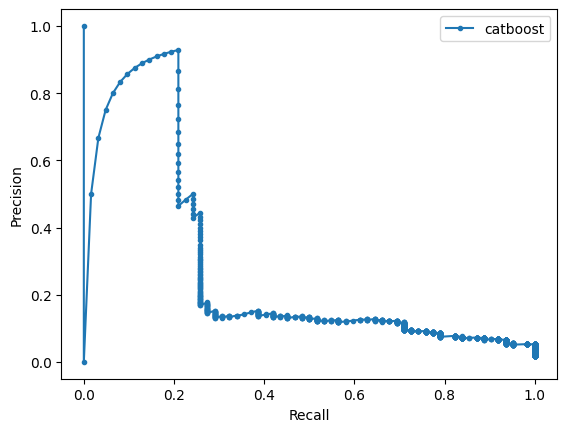

In [373]:
def plot_pr_curve(test_y, predictions):
    precision, recall, _ = precision_recall_curve(test_y, predictions)
    fig, ax = plt.subplots()
    ax.plot(recall, precision, marker=".", label="catboost")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()
#     st.pyplot(fig)
    
plot_pr_curve(y_test, model.predict_proba(X_test)[:, 1])

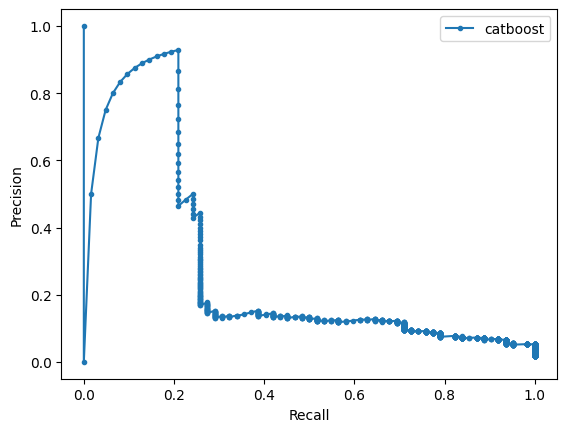

In [367]:
def plot_pr_curve(test_y, predictions):
    precision, recall, _ = precision_recall_curve(test_y, predictions)
    plt.plot(recall, precision, marker='.', label='catboost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

plot_pr_curve(y_test, model.predict_proba(X_test)[:, 1])

### Отбор фич с помощью RFECV

In [164]:


class BlockedTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits, train_size, test_size, col_date):
        self.test_size = test_size
        # n_splits с учетом дат, которые нужно сохранить для тестовой выборки
        self.n_splits = n_splits+test_size-1
        # вычисляем, сколько последних дат требуется оставить для кроссвалидации с такими параматрами
        self.n_dates = self.n_splits-1+test_size+train_size
        self.ts = TimeSeriesSplit(n_splits=self.n_splits, test_size=1, max_train_size=train_size)
        self.col_date = col_date
        
        
    def get_n_splits(self, X):
        return self.n_splits

    def split(self,X, y=None, groups = None):
#         display(X)
        X = self.col_date
        X = np.array(X)
        # Уникальные элементы списка
        X_uniq = np.unique(X)[-self.n_dates:]

        for train_index, test_index in self.ts.split(X_uniq):
            try:
                test_index = np.arange(test_index[0], test_index[0]+self.test_size)
                train_dates = X_uniq[train_index]
                test_dates = X_uniq[test_index]
                train_index = np.where(np.isin(X, train_dates))
                test_index = np.where(np.isin(X, test_dates))
                
                yield train_index[0], test_index[0]    
            except:
                break

btscv = BlockedTimeSeriesSplit(n_splits=4, train_size=3, test_size=3, col_date = df_train['report_date'])

In [165]:
list(df_train.select_dtypes('object').columns)

['report_date',
 'col520',
 'col552',
 'col543',
 'col527',
 'col607',
 'col600',
 'col599',
 'col560',
 'col548',
 'col551',
 'col535',
 'col540',
 'col464',
 'col152',
 'col228',
 'col559',
 'col460',
 'col472',
 'col568',
 'col468']

In [65]:

del_col = ['target', 'report_date', 'client_id']

rfecv = RFECV(
    estimator= CatBoostClassifier(verbose = 0, iterations=300, eval_metric='AUC', random_seed = 12345),
    step=0.1,
    cv=btscv,
    scoring="roc_auc",
    min_features_to_select=30,
#     n_jobs=2,
    verbose = 3
)
rfecv.fit(df_train.drop(columns = del_col+list(df_train.select_dtypes('object').columns)), df_train['target'])

print(f"Optimal number of features: {rfecv.n_features_}")

Fitting estimator with 607 features.
Fitting estimator with 547 features.
Fitting estimator with 487 features.
Fitting estimator with 427 features.
Fitting estimator with 367 features.
Fitting estimator with 307 features.
Fitting estimator with 247 features.
Fitting estimator with 187 features.
Fitting estimator with 127 features.
Fitting estimator with 67 features.
Fitting estimator with 607 features.
Fitting estimator with 547 features.
Fitting estimator with 487 features.
Fitting estimator with 427 features.
Fitting estimator with 367 features.
Fitting estimator with 307 features.
Fitting estimator with 247 features.
Fitting estimator with 187 features.
Fitting estimator with 127 features.
Fitting estimator with 67 features.
Fitting estimator with 607 features.
Fitting estimator with 547 features.
Fitting estimator with 487 features.
Fitting estimator with 427 features.
Fitting estimator with 367 features.
Fitting estimator with 307 features.
Fitting estimator with 247 features.
Fit

In [ ]:
good_features = rfecv.get_feature_names_out(df_train.drop(
    columns = del_col+list(df_train.select_dtypes('object').columns)
).columns)

### Тестирования стандартного CatBoost  

In [31]:
%%time
model = CatBoostClassifier(
    verbose = 100,
    learning_rate=0.01,
    eval_metric='AUC',
#     depth = 10,
#     iterations = 700,
    random_seed = 12345
) #iterations=100,

del_col = ['target', 'report_date', 'client_id']


pool_train = Pool(
#     df_train[list(good_features)+list(df_train.select_dtypes('object').columns)],#.drop(columns = del_col),
    df_train.drop(columns = del_col),
    label = df_train['target'],
    cat_features = list(df_train.drop(columns =del_col).select_dtypes('object').columns)
)


model.fit(pool_train,)


0:	total: 107ms	remaining: 1m 46s
100:	total: 9.23s	remaining: 1m 22s
200:	total: 18s	remaining: 1m 11s
300:	total: 26.9s	remaining: 1m 2s
400:	total: 35.7s	remaining: 53.3s
500:	total: 44.9s	remaining: 44.7s
600:	total: 53.7s	remaining: 35.7s
700:	total: 1m 2s	remaining: 26.7s
800:	total: 1m 11s	remaining: 17.8s
900:	total: 1m 20s	remaining: 8.87s
999:	total: 1m 29s	remaining: 0us
CPU times: user 4min 46s, sys: 41.5 s, total: 5min 27s
Wall time: 1min 30s


In [32]:
del_col = ['target', 'report_date', 'client_id']
# X_test = df_test[list(good_features)+list(df_train.select_dtypes('object').columns)]#.drop(columns = del_col)
X_test = df_test.drop(columns = del_col)
y_test = df_test['target']

print('roc_auc: ',roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
precision, recall,_ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1]) 
pr_auc = auc(recall, precision)
print('pr_auc: ',pr_auc)

roc_auc:  0.9055719846706297
pr_auc:  0.21847201552648698


<BarContainer object of 21 artists>

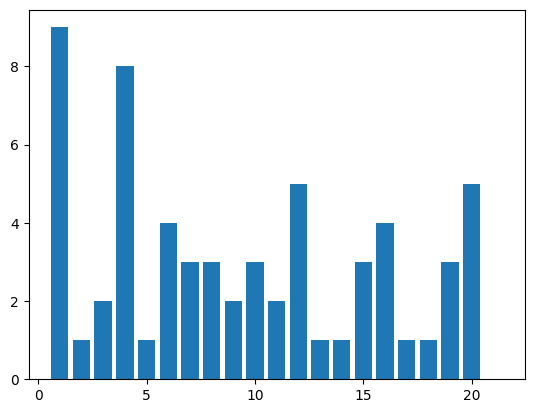

In [33]:
predictions = model.predict(df_test.drop(columns = del_col))

hist_df = pd.DataFrame(
    {
        'target':df_test['target'].values,
        'proba':predictions
    }
)
hist_df = hist_df.sort_values(by='proba', ascending=False)

num_segments = 20
segment_length = len(hist_df) // num_segments

array_21 = [21]*(len(hist_df)-num_segments*segment_length)
hist_df['segment'] = list(np.repeat(range(1, num_segments + 1), segment_length)) + array_21

hist_df = hist_df.groupby('segment')['target'].sum()
plt.bar(list(hist_df.index), list(hist_df.values))

### Cross Validation BlockedTimeSeriesSplit

In [21]:


class BlockedTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits, train_size, test_size, col_date):
        self.test_size = test_size
        # n_splits с учетом дат, которые нужно сохранить для тестовой выборки
        self.n_splits = n_splits+test_size-1
        # вычисляем, сколько последних дат требуется оставить для кроссвалидации с такими параматрами
        self.n_dates = self.n_splits-1+test_size+train_size
        self.ts = TimeSeriesSplit(n_splits=self.n_splits, test_size=1, max_train_size=train_size)
        self.col_date = col_date
        
        
    def get_n_splits(self, X):
        return self.n_splits

    def split(self,X, y=None, groups = None):
#         display(X)
        X = self.col_date
        X = np.array(X)
        # Уникальные элементы списка
        X_uniq = np.unique(X)[-self.n_dates:]

        for train_index, test_index in self.ts.split(X_uniq):
            try:
                test_index = np.arange(test_index[0], test_index[0]+self.test_size)
                train_dates = X_uniq[train_index]
                test_dates = X_uniq[test_index]
                train_index = np.where(np.isin(X, train_dates))
                test_index = np.where(np.isin(X, test_dates))
                
                yield train_index[0], test_index[0]    
            except:
                break

### Поиск гиперпараметров

In [23]:
%%time


def objective(trial):
    del_col = ['target', 'report_date', 'client_id']
    
    btscv = BlockedTimeSeriesSplit(n_splits=4, train_size=4, test_size=3, col_date =df_train['report_date'])
    
    params = {
        "iterations": 600, #trial.suggest_int("iterations", 500, 1200, step=150),
        "learning_rate": 0.01,#trial.suggest_float("learning_rate", 1e-3, 0.1, log=True)
        "depth": trial.suggest_int("depth", 5, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 1, 4),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 200),
    }
    
    model = CatBoostClassifier(
        **params,
        verbose = 0,
        eval_metric='AUC',
        random_seed = 12345,
        cat_features = list(df_train.drop(columns =del_col).select_dtypes('object').columns)
    )
    
    roc_auc = cross_val_score(
        model,
#         df_train.drop(columns = del_col),
#         df_train['target'],
        df_train.drop(columns = del_col),
        df_train['target'],
        cv=btscv,
        scoring="roc_auc",
        verbose = 3
    ).mean()
    
    return roc_auc


sampler = optuna.samplers.TPESampler(seed=12345)
study = optuna.create_study(study_name="CatBoost", direction="maximize", sampler=sampler)
study.optimize(
    objective,
    n_trials=15,
    n_jobs=-1
)

[I 2023-09-09 07:27:46,477] A new study created in memory with name: CatBoost


[CV] END ................................ score: (test=0.749) total time= 1.4min
[CV] END ................................ score: (test=0.749) total time= 1.4min
[CV] END ................................ score: (test=0.744) total time= 2.1min
[CV] END ................................ score: (test=0.762) total time= 1.6min
[CV] END ................................ score: (test=0.762) total time= 1.6min
[CV] END ................................ score: (test=0.756) total time= 4.5min
[CV] END ................................ score: (test=0.767) total time= 2.7min
[CV] END ................................ score: (test=0.768) total time= 2.0min
[CV] END ................................ score: (test=0.768) total time= 2.1min


[I 2023-09-09 07:34:29,651] Trial 0 finished with value: 0.7734582371719871 and parameters: {'depth': 5}. Best is trial 0 with value: 0.7734582371719871.


[CV] END ................................ score: (test=0.816) total time= 1.7min


[I 2023-09-09 07:34:48,520] Trial 1 finished with value: 0.7734582371719871 and parameters: {'depth': 5}. Best is trial 0 with value: 0.7734582371719871.


[CV] END ................................ score: (test=0.816) total time= 1.8min
[CV] END ................................ score: (test=0.776) total time= 3.1min
[CV] END ................................ score: (test=0.738) total time= 3.5min


[I 2023-09-09 07:38:36,201] Trial 3 finished with value: 0.7747863582046999 and parameters: {'depth': 6}. Best is trial 3 with value: 0.7747863582046999.


[CV] END ................................ score: (test=0.811) total time= 2.9min
[CV] END ................................ score: (test=0.773) total time= 6.6min
[CV] END ................................ score: (test=0.744) total time= 2.4min
[CV] END ................................ score: (test=0.763) total time= 4.6min
[CV] END ................................ score: (test=0.767) total time= 3.3min
[CV] END ................................ score: (test=0.762) total time=10.3min
[CV] END ................................ score: (test=0.780) total time= 7.9min
[CV] END ................................ score: (test=0.777) total time= 5.2min
[CV] END ................................ score: (test=0.776) total time= 3.5min


[I 2023-09-09 07:50:47,500] Trial 6 finished with value: 0.7747863582046999 and parameters: {'depth': 6}. Best is trial 3 with value: 0.7747863582046999.


[CV] END ................................ score: (test=0.811) total time= 3.0min


[I 2023-09-09 07:51:48,544] Trial 4 finished with value: 0.7758684422900176 and parameters: {'depth': 7}. Best is trial 4 with value: 0.7758684422900176.


[CV] END ................................ score: (test=0.825) total time= 4.1min


[I 2023-09-09 07:53:03,667] Trial 2 finished with value: 0.7805951879128645 and parameters: {'depth': 8}. Best is trial 2 with value: 0.7805951879128645.


[CV] END ................................ score: (test=0.813) total time= 6.3min
[CV] END ................................ score: (test=0.767) total time=11.8min
[CV] END ................................ score: (test=0.756) total time= 5.9min
[CV] END ................................ score: (test=0.760) total time=10.3min
[CV] END ................................ score: (test=0.762) total time=11.8min
[CV] END ................................ score: (test=0.773) total time= 8.2min
[CV] END ................................ score: (test=0.780) total time=13.9min
[CV] END ................................ score: (test=0.771) total time=11.5min
[CV] END ................................ score: (test=0.780) total time= 9.0min
[CV] END ................................ score: (test=0.767) total time=12.9min


[I 2023-09-09 08:22:39,235] Trial 8 finished with value: 0.7805951879128645 and parameters: {'depth': 8}. Best is trial 2 with value: 0.7805951879128645.


[CV] END ................................ score: (test=0.813) total time= 7.7min


[I 2023-09-09 08:22:50,484] Trial 5 finished with value: 0.783535657525789 and parameters: {'depth': 9}. Best is trial 5 with value: 0.783535657525789.


[CV] END ................................ score: (test=0.825) total time=12.0min
[CV] END ................................ score: (test=0.749) total time= 2.0min
[CV] END ................................ score: (test=0.764) total time=13.3min
[CV] END ................................ score: (test=0.762) total time= 2.4min
[CV] END ................................ score: (test=0.768) total time= 3.1min


[I 2023-09-09 08:32:38,857] Trial 10 finished with value: 0.7734582371719871 and parameters: {'depth': 5}. Best is trial 5 with value: 0.783535657525789.


[CV] END ................................ score: (test=0.816) total time= 2.5min
[CV] END ................................ score: (test=0.780) total time=15.0min
[CV] END ................................ score: (test=0.762) total time=12.1min
[CV] END ................................ score: (test=0.738) total time= 4.3min


[I 2023-09-09 08:39:49,385] Trial 7 finished with value: 0.7791980884823839 and parameters: {'depth': 10}. Best is trial 5 with value: 0.783535657525789.


[CV] END ................................ score: (test=0.822) total time=13.9min
[CV] END ................................ score: (test=0.763) total time= 5.3min


[I 2023-09-09 08:44:31,971] Trial 9 finished with value: 0.783535657525789 and parameters: {'depth': 9}. Best is trial 5 with value: 0.783535657525789.


[CV] END ................................ score: (test=0.825) total time=11.7min
[CV] END ................................ score: (test=0.777) total time= 5.5min
[CV] END ................................ score: (test=0.767) total time=12.8min
[CV] END ................................ score: (test=0.760) total time=10.7min


[I 2023-09-09 08:51:56,601] Trial 12 finished with value: 0.7758684422900176 and parameters: {'depth': 7}. Best is trial 5 with value: 0.783535657525789.


[CV] END ................................ score: (test=0.825) total time= 4.2min
[CV] END ................................ score: (test=0.760) total time=10.3min
[CV] END ................................ score: (test=0.780) total time=11.3min
[CV] END ................................ score: (test=0.771) total time= 9.8min
[CV] END ................................ score: (test=0.771) total time= 9.5min


[I 2023-09-09 09:07:52,619] Trial 11 finished with value: 0.783535657525789 and parameters: {'depth': 9}. Best is trial 5 with value: 0.783535657525789.


[CV] END ................................ score: (test=0.825) total time= 8.8min
[CV] END ................................ score: (test=0.764) total time= 9.8min
[CV] END ................................ score: (test=0.764) total time= 8.6min


[I 2023-09-09 09:17:55,249] Trial 13 finished with value: 0.7791980884823839 and parameters: {'depth': 10}. Best is trial 5 with value: 0.783535657525789.


[CV] END ................................ score: (test=0.822) total time= 7.8min


[I 2023-09-09 09:19:29,818] Trial 14 finished with value: 0.7791980884823839 and parameters: {'depth': 10}. Best is trial 5 with value: 0.783535657525789.


[CV] END ................................ score: (test=0.822) total time= 6.5min
CPU times: user 6h 3min 26s, sys: 1h 8min 3s, total: 7h 11min 29s
Wall time: 1h 51min 43s


In [24]:
trial = study.best_trial
trial

FrozenTrial(number=5, state=TrialState.COMPLETE, values=[0.783535657525789], datetime_start=datetime.datetime(2023, 9, 9, 7, 34, 48, 531836), datetime_complete=datetime.datetime(2023, 9, 9, 8, 22, 50, 484158), params={'depth': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'depth': IntDistribution(high=10, log=False, low=5, step=1)}, trial_id=5, value=None)

In [25]:
params =  study.best_params
print('Best hyperparameters:', params)
print('Best score:', study.best_value)

Best hyperparameters: {'depth': 9}
Best score: 0.783535657525789


0:	total: 624ms	remaining: 10m 23s
100:	total: 50.1s	remaining: 7m 25s
200:	total: 1m 41s	remaining: 6m 44s
300:	total: 2m 33s	remaining: 5m 55s
400:	total: 3m 23s	remaining: 5m 4s
500:	total: 4m 14s	remaining: 4m 13s
600:	total: 5m 5s	remaining: 3m 22s
700:	total: 5m 56s	remaining: 2m 32s
800:	total: 6m 47s	remaining: 1m 41s
900:	total: 7m 38s	remaining: 50.3s
999:	total: 8m 29s	remaining: 0us


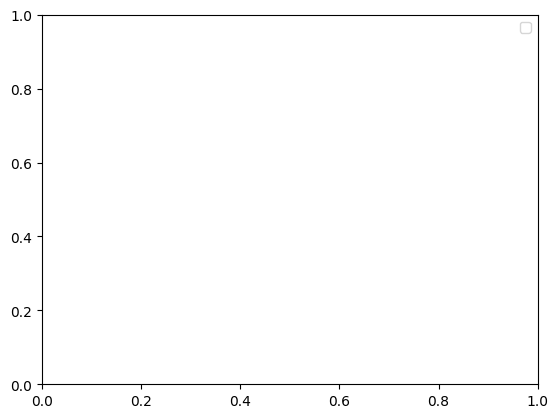

CPU times: user 25min 12s, sys: 5min 46s, total: 30min 58s
Wall time: 8min 30s


In [26]:
%%time
model = CatBoostClassifier(
    **params,
    verbose = 100,
    learning_rate=0.01,
    eval_metric='AUC',
#     iterations = 800,
    random_seed = 12345
) #iterations=100,

del_col = ['target', 'report_date', 'client_id']

pool_train = Pool(
    df_train.drop(columns = del_col),
    label = df_train['target'],
    cat_features = list(df_train.drop(columns =del_col).select_dtypes('object').columns)
)


model.fit(pool_train)


In [28]:
# df_test = df_test[df_train_v2.columns]
X_test_good = df_test.drop(columns = del_col)
y_test = df_test['target']

roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_good)[:, 1])
print('roc_auc: ',roc_auc)
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_good)[:, 1]) 
pr_auc = auc(recall, precision)
print('pr_auc: ',pr_auc)

roc_auc:  0.8242931289417302
pr_auc:  0.22014436320270309


### Отправка модели в MlFlow

In [ ]:
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://161.35.150.68:9000'
os.environ["AWS_ACCESS_KEY_ID"] = "6owG9ybVXncQyUFCu7eTEn_mteDf12aAKUgkqLJj76e2V5Yz7NxlVSJnly5dfPH-InWnHdBru062ABgJRU2Z0A"
os.environ["AWS_SECRET_ACCESS_KEY"] = "Gh85cb1UQ2vWO1AvRl9Dld94gKluLnBnvC-tCfSntBikx_A_dD4G842d7RejjDR6BTH0Ko2qaWidswbjm_at4Q"
os.environ["MLFLOW_TRACKING_URI"] = "http://161.35.150.68:5000"

mlflow.set_experiment(experiment_name=f'Hack test v1')
client = MlflowClient()

In [ ]:

    
# Data to be written
columns_dict = {'columns': list(selection_rfe)}
    
with open("/content/artifacts/columns.json", "w") as outfile:
    json.dump(columns_dict, outfile)

In [ ]:
predictions  = model.predict(df_test.drop(columns = del_col))
signature = infer_signature(df_test.drop(columns = del_col, axis=1), predictions)

metrics_to_mlflow = {
    'pr_auc': pr_auc,
    'roc_auc':roc_auc
}

with mlflow.start_run(run_name=f'CatBoost_v2'):
    mlflow.log_params(model.get_params())
#     mlflow.log_param('columns', list(df_test.drop(columns = del_col).columns))
    mlflow.log_metrics(metrics_to_mlflow)
    
    mlflow.sklearn.log_model(
        model,
        signature=signature,
        registered_model_name=f'CatBoost',
        artifact_path='art'
    )
    mlflow.set_tags({'model': 'boosting v2'})
    
    mlflow.log_artifacts('/kaggle/working/columns.json')
    
    print(f'Model saved in run {mlflow.active_run().info.run_uuid}')
mlflow.end_run()